# Предсказание цены закрытия свечи - Биктоин - Временной интервал 15 минут

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN,ConvLSTM2D, RNN, ConvLSTM1D, ConvLSTM3D
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D, Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import keras_tuner
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
import cryptocompare

In [5]:
pip install cryptocompare

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for cryptocompare: filename=cryptocompare-0.7.6-py3-none-any.whl size=6290 sha256=ac405862cf9e63cbda092fed9ef3618c634bb91337fff2df01ee1cefc448fd51
  Stored in directory: /root/.cache/pip/wheels/97/81/6a/261bc499b9d9bf8b391eea52c90a4746b477539564b0a66c94
Successfully built cryptocompare


In [6]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.6 MB/s eta 0:00:00


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from datetime import date, timedelta, datetime
import seaborn as sns
sns.set_style('white', {'axes.spines.right': True, 'axes.spines.top': False})

import san
san.ApiConfig.api_key = "5g33k3hjcghlfotr_ggr666n4uu4ejwr3"

# Data Collection

In [3]:
OHLCV = []
end = datetime(2023,7,7, 10)
for i in range(1):
    start = end - timedelta(days = 20)
    part = san.get(
          "ohlc",
          slug="bitcoin",
          from_date=start,
          to_date=end,
          interval="30m"
        )
    OHLCV.append(part)
    end = start

OHLCV = list(reversed(OHLCV))
OHLCV = pd.concat(OHLCV)
OHLCV

,closePriceUsd,highPriceUsd,lowPriceUsd,openPriceUsd
datetime,,,,
2023-06-17 10:00:00+00:00,26601.899362,26601.899362,26573.913437,26577.540073
2023-06-17 10:30:00+00:00,26587.187251,26619.024777,26587.187251,26619.024777
2023-06-17 11:00:00+00:00,26541.581961,26585.542224,26529.281241,26573.972484
2023-06-17 11:30:00+00:00,26513.034711,26549.007785,26508.899327,26539.358014
2023-06-17 12:00:00+00:00,26547.337997,26562.633621,26435.768317,26435.768317
...,...,...,...,...
2023-07-07 07:30:00+00:00,30037.188350,30123.817431,30006.110184,30083.780140
2023-07-07 08:00:00+00:00,30029.616182,30068.975488,30007.761713,30007.761713
2023-07-07 08:30:00+00:00,30078.147246,30099.121749,30036.289230,30036.289230


In [4]:
datetime.now()

datetime.datetime(2023, 7, 11, 16, 46, 4, 100156)

In [5]:
OHLCV.rename(columns={'closePriceUsd':'close', 'highPriceUsd':'high', 'lowPriceUsd':'low', 'openPriceUsd':'open'}, inplace=True)

In [6]:
OHLCV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 960 entries, 2023-06-17 10:00:00+00:00 to 2023-07-07 09:30:00+00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   960 non-null    float64
 1   high    960 non-null    float64
 2   low     960 non-null    float64
 3   open    960 non-null    float64
dtypes: float64(4)
memory usage: 37.5 KB


In [7]:
OHLCV.describe()

,close,high,low,open
count,960.000000,960.000000,960.000000,960.000000
mean,29771.942918,29810.626957,29727.794261,29768.237297
std,1495.558494,1499.497643,1492.992485,1498.410830
min,26336.213003,26380.006072,26312.831808,26351.654624
25%,30030.799523,30070.451605,29974.957060,30035.498115
50%,30412.652084,30453.129495,30378.794150,30413.305228
75%,30625.520583,30667.074041,30597.718155,30628.695735
max,31392.284867,31427.465912,31359.123708,31427.465912


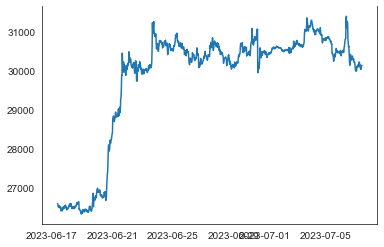

In [8]:
plt.plot(OHLCV['close'])

Bybit

In [9]:
import json 
import requests 
import pandas as pd
import datetime as dt
from time import sleep

In [10]:
symbol = 'BTCUSDT'

year = 2023
month = 7
day = 9

### Settings Block End   ###


def get_linenumber():
    cf = currentframe()
    global line_number
    line_number = cf.f_back.f_lineno


def get_bybit_bars(symbol, interval, startTime, endTime):

    url = 'https://api.bybit.com/public/linear/kline'
    startTime = str(int(startTime.timestamp()))
    endTime   = str(int(endTime.timestamp()))
    req_params = {'symbol' : symbol, 'interval' : interval, 'from' : startTime, 'to' : endTime}
    df = pd.DataFrame(json.loads(requests.get(url, params = req_params).text)['result'])
    if (len(df.index) == 0):
        return None
    
    df.index = [dt.datetime.fromtimestamp(x) for x in df.open_time]
    return df


df_list = []
end_time = dt.datetime(year, month, day)
delta = dt.timedelta(hours=50)
start_time = end_time - delta

for i in range(200):
    new_df = get_bybit_bars(symbol, 15, start_time, end_time)
    df_list = [new_df] + df_list
    end_time = start_time
    start_time = end_time - delta 
    
df = pd.concat(df_list)
OHLCV = df[['open','high','low','close']]
print(OHLCV)

                        open     high      low    close
2022-05-18 08:00:00  29821.0  29821.0  29743.0  29802.5
2022-05-18 08:15:00  29802.5  29922.0  29740.0  29855.0
2022-05-18 08:30:00  29855.0  29878.0  29800.0  29845.5
2022-05-18 08:45:00  29845.5  29891.5  29781.0  29810.0
2022-05-18 09:00:00  29810.0  29968.5  29768.5  29899.0
...                      ...      ...      ...      ...
2023-07-08 22:45:00  30196.1  30196.2  30170.5  30187.9
2023-07-08 23:00:00  30187.9  30187.9  30170.1  30173.1
2023-07-08 23:15:00  30173.1  30176.0  30025.0  30101.3
2023-07-08 23:30:00  30101.3  30112.0  30060.0  30111.9
2023-07-08 23:45:00  30111.9  30119.7  30094.1  30096.3

[40000 rows x 4 columns]


In [11]:
OHLCV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40000 entries, 2022-05-18 08:00:00 to 2023-07-08 23:45:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    40000 non-null  float64
 1   high    40000 non-null  float64
 2   low     40000 non-null  float64
 3   close   40000 non-null  float64
dtypes: float64(4)
memory usage: 1.5 MB


In [12]:
OHLCV.describe()

,open,high,low,close
count,40000.000000,40000.000000,40000.00000,40000.000000
mean,23040.204875,23082.275310,22997.32685,23040.211757
std,4408.835368,4415.723026,4401.41922,4408.846168
min,15632.500000,15707.500000,15440.00000,15632.500000
25%,19512.375000,19550.000000,19481.00000,19512.375000
50%,22423.000000,22468.450000,22387.70000,22423.000000
75%,27152.300000,27180.675000,27120.00000,27152.300000
max,32284.000000,32450.000000,32125.00000,32284.000000


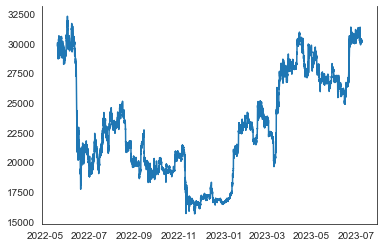

In [13]:
plt.plot(OHLCV['close'])

In [14]:
OHLCV[-205:-195]

,open,high,low,close
2023-07-06 20:45:00,30244.0,30316.3,30140.0,30300.0
2023-07-06 21:00:00,30300.0,30339.3,30230.4,30248.5
2023-07-06 21:15:00,30248.5,30270.0,30215.0,30223.9
2023-07-06 21:30:00,30223.9,30282.7,30187.6,30245.6
2023-07-06 21:45:00,30245.6,30282.3,30215.5,30282.3
2023-07-06 22:00:00,30282.3,30327.7,30278.0,30310.5
2023-07-06 22:15:00,30310.5,30310.5,30222.1,30262.3
2023-07-06 22:30:00,30262.3,30285.0,30196.1,30208.8
2023-07-06 22:45:00,30208.8,30385.0,30208.7,30368.6
2023-07-06 23:00:00,30368.6,30368.6,30252.4,30264.0


# Data prepocessing

Преобразуем наш датасет. Попробуем предоставить модели полную картину, происходящую на графике биржи, которые видят трейдеры, прогнозирующие цену с помощью технического анализа. Наш датасет будет состоять из следующих данных:

close - цена закрытия свечи;

low - цена низшей точки свечи;

high - цена высшей точки свечи;

open - цена открытия свечи;

close_diff - разница между ценами закрытия соседних свечей;

low_diff - разница между ценами низших точек соседних свечей;

high_diff - разница между ценами высших точек соседних свечей;

open_diff - разница между ценами открытия соседних свечей;

color_of_candle - цвет свечи(красный или зеленый, красный цвет - цена закрытия свечи ниже цены открытия, зеленый цвет - цена закрытия свечи выше цены открытия)

number_candle_trend - порядковый номер свечи в тренде(обозначает порядковый номер свечи в последовательности свечей одинакового цвета)

SMA_200 - 200-пятнадцатиминутная скользящая средняя

EMA_200 - 200-пятнадцатиминутная скользящая экспоненциальная

SMA_50 - 50-пятнадцатиминутная скользящая средняя

EMA_50 - 50-пятнадцатиминутная скользящая экспоненциальная

RSI - индекс относительной силы

MACD - линия MACD, является результатом взятия более долгосрочной EMA и вычитания ее из более краткосрочной EMA.Наиболее часто используемые значения - 26 для долгосрочной EMA и 12 для краткосрочной EMA

Signal - Сигнальная линия представляет собой EMA линии MACD, описанной в MACD. Трейдер может выбрать, какую EMA длины периода использовать для сигнальной линии, однако 9 является наиболее распространенной.

Histogram - С течением времени разница между линией MACD и сигнальной линией будет постоянно меняться. Гистограмма MACD учитывает это различие и отображает его в виде легко читаемой гистограммы. Разница между двумя линиями колеблется вокруг нулевой линии.

width_open_close - разница между ценой открытия и закрытия свечи

width_open_high - разница между ценой открытия и высшей ценой свечи

width_open_low - разница между ценой открытия и низшей ценой свечи

In [15]:
columns = {}
columns['close'] = list(OHLCV['close'].values)

SMA и EMA

In [16]:
SMA_200 = OHLCV['close'].rolling(window = 200).mean()
EMA_200 = OHLCV['close'].ewm(span=200).mean()
SMA_50 = OHLCV['close'].rolling(window = 50).mean()
EMA_50 = OHLCV['close'].ewm(span=50).mean()

SMA_200 = SMA_200.dropna()
EMA_200 = EMA_200.dropna()
SMA_50 = SMA_50.dropna()
EMA_50 = EMA_50.dropna()

columns['SMA_200'] = list(SMA_200.values)
columns['EMA_200'] = list(EMA_200.values)
columns['SMA_50'] = list(SMA_50.values)
columns['EMA_50'] = list(EMA_50.values)

RSI

In [17]:
def calculate_rsi(data, window=14):
    close = data['close']
    delta = close.diff()
    delta = delta[1:]

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up = up.rolling(window).mean()
    roll_down = np.abs(down.rolling(window).mean())

    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

rsi = calculate_rsi(OHLCV)
rsi = rsi.dropna()
rsi

2022-05-18 11:30:00    51.935298
2022-05-18 11:45:00    52.320917
2022-05-18 12:00:00    50.000000
2022-05-18 12:15:00    49.138859
2022-05-18 12:30:00    42.048055
                         ...    
2023-07-08 22:45:00    46.883348
2023-07-08 23:00:00    42.023346
2023-07-08 23:15:00    33.750000
2023-07-08 23:30:00    30.744102
2023-07-08 23:45:00    30.434783
Name: close, Length: 39986, dtype: float64

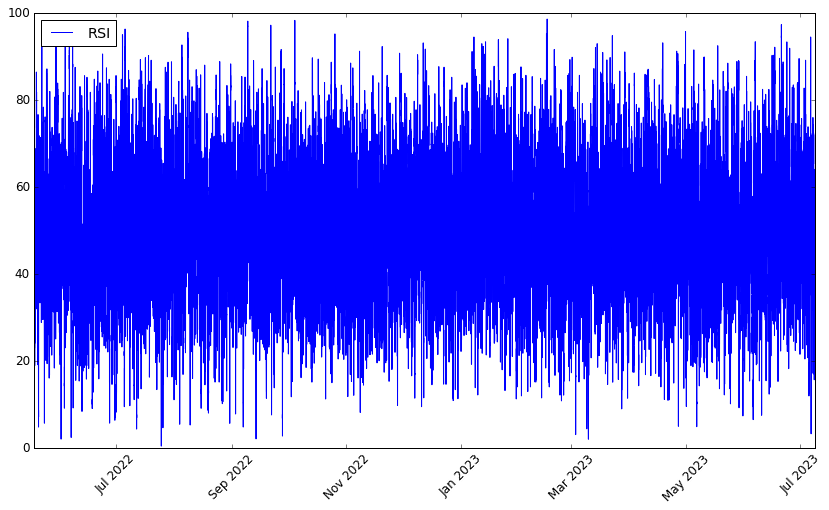

In [18]:
plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(rsi, label='RSI', color = 'blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()
columns['RSI'] = list(rsi.values)

MACD

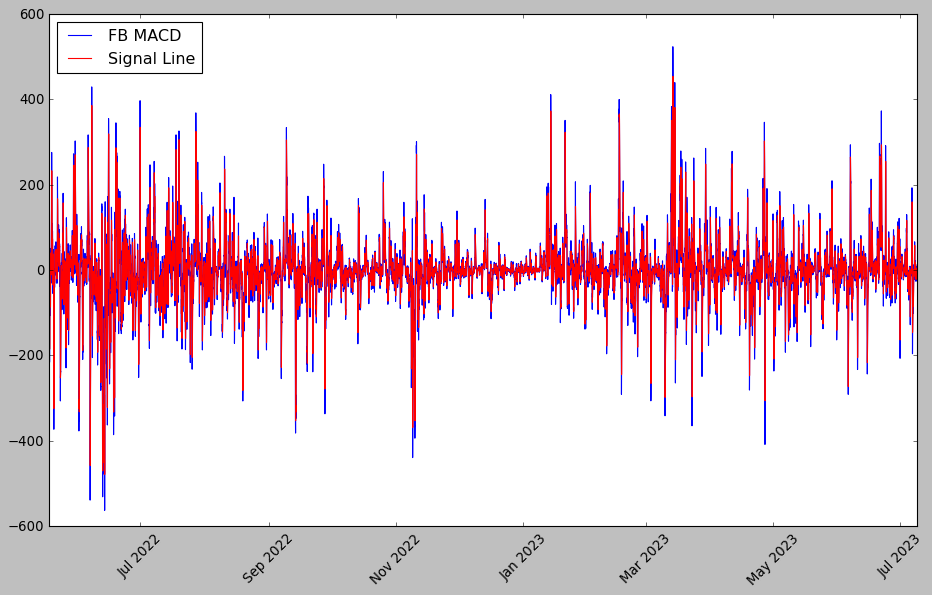

In [19]:
def calculate_macd(data, fast=12, slow=26, signal=9):
    close = data['close']
    exp1 = close.ewm(span=fast, min_periods=fast).mean()
    exp2 = close.ewm(span=slow, min_periods=slow).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, min_periods=signal).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

macd, signal_line, histogram = calculate_macd(OHLCV)

plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(OHLCV.index, macd, label='FB MACD', color = 'blue')
plt.plot(OHLCV.index, signal_line, label='Signal Line', color='red')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [20]:
macd = macd.dropna()
signal_line = signal_line.dropna()
histogram = histogram.dropna()

columns['macd'] = list(macd.values)
columns['signal_line'] = list(signal_line.values)
columns['histogram'] = list(histogram.values)

close_diff low_diff open_diff high_diff

In [21]:
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
     value = dataset[i] - dataset[i - interval]
     diff.append(value)
 return diff
# df1 = df[1:]
def difference_for_every_column(df, df1): 
    for column in df.columns.values:
        diff = difference(df[column])
        df1[column+'_diff'] = diff
    return df1

In [22]:
diff_df = pd.DataFrame()
diff_df = difference_for_every_column(OHLCV[['close', 'low', 'open', 'high']] , diff_df) 
diff_df  

,close_diff,low_diff,open_diff,high_diff
0,52.5,-3.0,-18.5,101.0
1,-9.5,60.0,52.5,-44.0
2,-35.5,-19.0,-9.5,13.5
3,89.0,-12.5,-35.5,77.0
4,47.5,129.0,89.0,40.5
...,...,...,...,...
39994,-8.2,-21.3,4.2,-8.4
39995,-14.8,-0.4,-8.2,-8.3
39996,-71.8,-145.1,-14.8,-11.9
39997,10.6,35.0,-71.8,-64.0


In [23]:
columns['close_diff'] = list(diff_df['close_diff'].values)
columns['low_diff'] = list(diff_df['low_diff'].values)
columns['open_diff'] = list(diff_df['open_diff'].values)
columns['high_diff'] = list(diff_df['high_diff'].values)

width_open_close, width_open_high, width_open_low

In [24]:
close_values = OHLCV['close'].values
low_values = OHLCV['low'].values
open_values = OHLCV['open'].values
high_values = OHLCV['high'].values
width_open_close = np.zeros(shape= len(OHLCV))
width_open_high = np.zeros(shape=len(OHLCV))
width_open_low = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    width_open_close[i] = close_values[i] - open_values[i] 
    width_open_high[i] = high_values[i] - open_values[i]
    width_open_low[i] = open_values[i] - low_values[i]

columns['width_open_close'] = list(width_open_close)
columns['width_open_high'] = list(width_open_high)
columns['width_open_low'] = list(width_open_low)

color_of_candle, number_candle_trend

In [25]:
color_of_candle = []
number_candle_trend = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    if width_open_close[i] > 0:
        color_of_candle.append('green')
    else:
        color_of_candle.append('red')
        
number_candle_trend[0] = 1
cnt = 1
for i in range(1,len(OHLCV)):
    if (color_of_candle[i] == color_of_candle[i - 1]):
        cnt = cnt + 1
        number_candle_trend[i] = cnt
    else:
        cnt = 1
        number_candle_trend[i] = cnt

columns['color_of_candle'] = color_of_candle
columns['number_candle_trend'] = number_candle_trend

Соберем все признаки в один датасет

In [26]:
for key, value in columns.items():
    print(key, " -> ", len(value))

close  ->  40000
SMA_200  ->  39801
EMA_200  ->  40000
SMA_50  ->  39951
EMA_50  ->  40000
RSI  ->  39986
macd  ->  39975
signal_line  ->  39967
histogram  ->  39967
close_diff  ->  39999
low_diff  ->  39999
open_diff  ->  39999
high_diff  ->  39999
width_open_close  ->  40000
width_open_high  ->  40000
width_open_low  ->  40000
color_of_candle  ->  40000
number_candle_trend  ->  40000


In [27]:
df_candles = pd.DataFrame({})
for key, value in columns.items():
    df_candles[key] = value[-(len(SMA_200)):]
    
df_candles

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend
0,30180.5,29594.9225,29760.195975,30204.200,30122.733561,41.001565,-27.127963,-11.763803,-15.364161,22.5,41.0,68.0,27.5,22.5,27.5,52.0,green,3.0
1,30147.5,29596.6475,29764.645988,30205.080,30123.705107,33.656958,-26.053765,-14.621795,-11.431970,-33.0,20.0,22.5,-5.0,-33.0,0.0,54.5,red,1.0
2,29986.5,29597.3050,29767.191109,30201.370,30118.322850,27.844712,-37.758551,-19.249146,-18.509405,-161.0,-172.0,-33.0,-33.0,-161.0,0.0,193.5,red,2.0
3,29935.5,29597.7550,29769.119024,30193.920,30111.151195,29.524485,-50.567046,-25.512726,-25.054320,-51.0,-113.5,-161.0,-160.5,-51.0,0.5,146.0,red,3.0
4,30003.5,29598.7225,29771.799736,30189.880,30106.928373,35.267275,-54.601428,-31.330467,-23.270961,68.0,25.5,-51.0,18.0,68.0,69.5,69.5,green,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39796,30187.9,30201.8715,30271.242551,30205.764,30213.438528,46.883348,-0.800033,2.850740,-3.650774,-8.2,-21.3,4.2,-8.4,-8.2,0.1,25.6,red,1.0
39797,30173.1,30201.4945,30270.266008,30205.842,30211.856625,42.023346,-3.581549,1.564282,-5.145832,-14.8,-0.4,-8.2,-8.3,-14.8,0.0,17.8,red,2.0
39798,30101.3,30200.8815,30268.584755,30204.500,30207.521071,33.750000,-11.447619,-1.038098,-10.409521,-71.8,-145.1,-14.8,-11.9,-71.8,2.9,148.1,red,3.0
39799,30111.9,30200.2130,30267.025702,30203.046,30203.771225,30.744102,-16.634454,-4.157369,-12.477085,10.6,35.0,-71.8,-64.0,10.6,10.7,41.3,green,1.0


In [28]:
percent = []
for index, row in df_candles.iterrows():
    percent.append(abs(row['close_diff'])/row['close'])

change_percent_mean = np.array(percent).mean()

In [29]:
#делаем сдвиг по целевой переменной, чтобы для каждой строки целевой переменной стало значения закрытия цены на следующей свече
df_close_next = df_candles['close'][1:].values
df_candles = df_candles[:-1]
df_candles['close_next'] = df_close_next
df_candles

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next
0,30180.5,29594.9225,29760.195975,30204.200,30122.733561,41.001565,-27.127963,-11.763803,-15.364161,22.5,41.0,68.0,27.5,22.5,27.5,52.0,green,3.0,30147.5
1,30147.5,29596.6475,29764.645988,30205.080,30123.705107,33.656958,-26.053765,-14.621795,-11.431970,-33.0,20.0,22.5,-5.0,-33.0,0.0,54.5,red,1.0,29986.5
2,29986.5,29597.3050,29767.191109,30201.370,30118.322850,27.844712,-37.758551,-19.249146,-18.509405,-161.0,-172.0,-33.0,-33.0,-161.0,0.0,193.5,red,2.0,29935.5
3,29935.5,29597.7550,29769.119024,30193.920,30111.151195,29.524485,-50.567046,-25.512726,-25.054320,-51.0,-113.5,-161.0,-160.5,-51.0,0.5,146.0,red,3.0,30003.5
4,30003.5,29598.7225,29771.799736,30189.880,30106.928373,35.267275,-54.601428,-31.330467,-23.270961,68.0,25.5,-51.0,18.0,68.0,69.5,69.5,green,1.0,30143.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,30196.1,30202.4320,30272.080165,30205.654,30214.480917,54.090909,1.254920,3.763434,-2.508514,4.2,7.1,-0.1,8.3,4.2,12.7,0.1,green,1.0,30187.9
39796,30187.9,30201.8715,30271.242551,30205.764,30213.438528,46.883348,-0.800033,2.850740,-3.650774,-8.2,-21.3,4.2,-8.4,-8.2,0.1,25.6,red,1.0,30173.1
39797,30173.1,30201.4945,30270.266008,30205.842,30211.856625,42.023346,-3.581549,1.564282,-5.145832,-14.8,-0.4,-8.2,-8.3,-14.8,0.0,17.8,red,2.0,30101.3
39798,30101.3,30200.8815,30268.584755,30204.500,30207.521071,33.750000,-11.447619,-1.038098,-10.409521,-71.8,-145.1,-14.8,-11.9,-71.8,2.9,148.1,red,3.0,30111.9


Кодируем категориальные переменнные

In [30]:
df_candles_supervised = df_candles.copy()

number_candle_trend_encoder = LabelEncoder()
df_candles_supervised["color_of_candle"] = number_candle_trend_encoder.fit_transform(df_candles_supervised["color_of_candle"])
color_of_candle_encoder = LabelEncoder()
df_candles_supervised["number_candle_trend"] = color_of_candle_encoder.fit_transform(df_candles_supervised["number_candle_trend"])


df_candles_supervised

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next
0,30180.5,29594.9225,29760.195975,30204.200,30122.733561,41.001565,-27.127963,-11.763803,-15.364161,22.5,41.0,68.0,27.5,22.5,27.5,52.0,0,2,30147.5
1,30147.5,29596.6475,29764.645988,30205.080,30123.705107,33.656958,-26.053765,-14.621795,-11.431970,-33.0,20.0,22.5,-5.0,-33.0,0.0,54.5,1,0,29986.5
2,29986.5,29597.3050,29767.191109,30201.370,30118.322850,27.844712,-37.758551,-19.249146,-18.509405,-161.0,-172.0,-33.0,-33.0,-161.0,0.0,193.5,1,1,29935.5
3,29935.5,29597.7550,29769.119024,30193.920,30111.151195,29.524485,-50.567046,-25.512726,-25.054320,-51.0,-113.5,-161.0,-160.5,-51.0,0.5,146.0,1,2,30003.5
4,30003.5,29598.7225,29771.799736,30189.880,30106.928373,35.267275,-54.601428,-31.330467,-23.270961,68.0,25.5,-51.0,18.0,68.0,69.5,69.5,0,0,30143.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,30196.1,30202.4320,30272.080165,30205.654,30214.480917,54.090909,1.254920,3.763434,-2.508514,4.2,7.1,-0.1,8.3,4.2,12.7,0.1,0,0,30187.9
39796,30187.9,30201.8715,30271.242551,30205.764,30213.438528,46.883348,-0.800033,2.850740,-3.650774,-8.2,-21.3,4.2,-8.4,-8.2,0.1,25.6,1,0,30173.1
39797,30173.1,30201.4945,30270.266008,30205.842,30211.856625,42.023346,-3.581549,1.564282,-5.145832,-14.8,-0.4,-8.2,-8.3,-14.8,0.0,17.8,1,1,30101.3
39798,30101.3,30200.8815,30268.584755,30204.500,30207.521071,33.750000,-11.447619,-1.038098,-10.409521,-71.8,-145.1,-14.8,-11.9,-71.8,2.9,148.1,1,2,30111.9


Преобразованный датасет имеет 32440 строк и 19 колонок

In [31]:
df_candles_supervised.loc[16000:, 'color_of_candle'].value_counts()

0    11912
1    11888
Name: color_of_candle, dtype: int64

# Feature Selection

Определим наилучший метод для отбора признаков

Функция разбиения датасета и нормализации

In [32]:
def split_normalization_for_VIF_RFE_PCA(dataset):
    split = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split)
    val = train[i_split_val:]
    train = train[:i_split_val]

    features = dataset.drop(['color_of_candle', 'number_candle_trend'], axis =1).columns.values
    # train

    train_norm = train.loc[:, features].values
    train_norm = scaler.fit_transform(train_norm)
    train_norm = pd.DataFrame(train_norm, columns=features)

    train_categorial = train.loc[:,['color_of_candle', 'number_candle_trend']].reset_index()
    train_std = pd.concat([train_norm, train_categorial], axis=1)
    
    # test

    test_norm = test.loc[:, features].values
    test_norm = scaler.transform(test_norm)
    test_norm = pd.DataFrame(test_norm, columns=features)
    

    test_categorial = test.loc[:,['color_of_candle', 'number_candle_trend']].reset_index()
    test_std = pd.concat([test_norm, test_categorial], axis=1)
    
    # val
    val_norm = val.loc[:, features].values
    val_norm = scaler.transform(val_norm)
    val_norm = pd.DataFrame(val_norm, columns=features)

    val_categorial = val.loc[:,['color_of_candle', 'number_candle_trend']].reset_index()
    val_std = pd.concat([val_norm, val_categorial], axis=1)



    train_X = train_std.drop(['close_next', 'index'],axis=1)
    # train_X.index = train_X['date']
    # train_X = train_X.drop(['date'],axis=1)
    train_y = train_std['close_next']
    
    test_X = test_std.drop(['close_next', 'index'],axis=1)
    # test_X.index = test_X['date']
    # test_X = test_X.drop(['date'],axis=1)
    test_y = test_std['close_next']


    val_X = val_std.drop(['close_next', 'index'],axis=1)
    # val_X.index = val_X['date']
    # val_X = val_X.drop(['date'],axis=1)
    val_y = val_std['close_next']

    return train_X, train_y, test_X, test_y, val_X, val_y

Функция создания последовательностей

In [33]:
# multivariate output data prep
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(df, n_steps):

    columns = df.columns.values

    arrays = []
    for column in columns:
        values = df[column].values
        a = values.reshape(len(values), 1)
        arrays.append(a)

    sequences = hstack((arrays))

    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences)-1:
            break

        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X)

Метрики

In [34]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


def count_money(real, forecast):
    profit = 0
    for i in range(1, len(real)):
        if ((forecast[i] > real[i-1]) & (real[i] > real[i-1])) | ((forecast[i] < real[i-1]) & (real[i] < real[i-1])):
            profit = profit + abs(real[i] - real[i-1])
        else:
            profit = profit - abs(real[i] - real[i-1])
    return profit

def count_money_2(real, forecast):
    profit = 0
    for i in range(1, len(real)):
        if ((forecast[i] > real[i-1]) & (real[i] > real[i-1])):
            if (forecast[i] > real[i]):
                profit = profit + abs(real[i] - real[i-1])
            else:
                profit = profit + abs(forecast[i] - real[i-1])
        elif ((forecast[i] < real[i-1]) & (real[i] < real[i-1])):
            if (forecast[i] < real[i]):
                profit = profit + abs(real[i] - real[i-1])
            else:
                profit = profit + abs(forecast[i] - real[i-1])
        else:
            profit = profit - abs(real[i] - real[i-1])
    return profit

def direction(real, forecast):
    directions = []
    for i in range(1, len(real)):
        if ((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1])):
                directions.append(1)
        else:
            directions.append(0)
    return sum(directions)/len(directions)


def success_prediction(real, forecast, diff = change_percent_mean, type_of_diff = 'percent'):
    success_prediction = []
    if (type_of_diff == 'absolute'):
        for i in range(1, len(real)):
            if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
               & (abs(forecast[i] - real[i]) < diff)):
                    success_prediction.append(1)
            else:
                success_prediction.append(0)
    else: 
        diff = round(diff, 2)
        for i in range(1, len(real)):
            if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
               & (abs(forecast[i] - real[i]) / real[i] < diff)):
                    success_prediction.append(1)
            else:
                success_prediction.append(0)
    return sum(success_prediction)/len(success_prediction)

def success_prediction_with_change_price(real, forecast, change_price = 5, diff = 250, type_of_diff = 'percent'):
    change_price = round(change_price/100, 2)
    success_prediction_with_change_price = []
    if (type_of_diff == 'absolute'):
        for i in range(1, len(real)):
            if (abs(real[i] - real[i-1]) / real[i-1] < change_price):
                if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
                   & (abs(forecast[i] - real[i]) < diff)):
                        success_prediction_with_change_price.append(1)
                else:
                    success_prediction_with_change_price.append(0)
    else: 
        diff = round(diff/100, 2)
        for i in range(1, len(real)):
            if (abs(real[i] - real[i-1]) / real[i-1] < change_price):
                if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
                   & (abs(forecast[i] - real[i]) / real[i] < diff)):
                        success_prediction_with_change_price.append(1)
                else:
                    success_prediction_with_change_price.append(0)
    return sum(success_prediction_with_change_price)/len(success_prediction_with_change_price)




def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стационарность:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значение = {:.3f}".format(dftest[1]))
    print("Критические значения :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Данные {} стационарны с вероятностью {}% процентов".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    #real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    print('Среднее угадывание направления: ', direction(real, forecast))
    # print('Процент удачных предсказаний: ', success_prediction(real, forecast))
    # print('Процент удачных предсказаний c разницей между соседними ценами в 2: ', success_prediction_with_change_price(real, forecast))
    print('R2:', round(r2_score(real, forecast),20))
    print('SMAPE:', round(np.sqrt(smape(real, forecast)),20))
    print('Прибыль, при условии закрытия сделки по каждой свечи:', round(count_money(real, forecast), 20))
    print('Прибыль, при условии закрытия сделки по каждой свечи (способ 2):', round(count_money_2(real, forecast), 20))
    
    plt.plot(real-forecast)
    

    
    
def metrics_short(real, forecast):
    real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    print('R2:', round(r2_score(real, forecast),20))
    print('SMAPE:', round(np.sqrt(smape(real, forecast)),20))

VIF

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_creation(X):
    vif_df = pd.DataFrame()
    vif_df['Feature Name'] = X.columns
    vif_df['Vif Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

vif_df = df_candles_supervised.drop(['close_next'], axis =1)
vif_df = vif_creation(vif_df)
vif_df

,Feature Name,Vif Factor
0,close,4.307615e+05
1,SMA_200,6.629380e+04
2,EMA_200,8.467419e+04
3,SMA_50,7.262505e+05
4,EMA_50,1.137434e+06
5,RSI,1.606787e+01
6,macd,inf
7,signal_line,inf
8,histogram,inf
9,close_diff,inf


Выберем признаки со значением меньше 5

In [36]:
columns_vif = ['close']
for index, row in vif_df.iterrows():
    if (row['Vif Factor'] < 20):
      columns_vif.append(row['Feature Name'])

columns_vif.append('close_next')


df_candles_VIF = df_candles_supervised[columns_vif]

df_candles_VIF


,close,RSI,low_diff,open_diff,high_diff,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next
0,30180.5,41.001565,41.0,68.0,27.5,27.5,52.0,0,2,30147.5
1,30147.5,33.656958,20.0,22.5,-5.0,0.0,54.5,1,0,29986.5
2,29986.5,27.844712,-172.0,-33.0,-33.0,0.0,193.5,1,1,29935.5
3,29935.5,29.524485,-113.5,-161.0,-160.5,0.5,146.0,1,2,30003.5
4,30003.5,35.267275,25.5,-51.0,18.0,69.5,69.5,0,0,30143.5
...,...,...,...,...,...,...,...,...,...,...
39795,30196.1,54.090909,7.1,-0.1,8.3,12.7,0.1,0,0,30187.9
39796,30187.9,46.883348,-21.3,4.2,-8.4,0.1,25.6,1,0,30173.1
39797,30173.1,42.023346,-0.4,-8.2,-8.3,0.0,17.8,1,1,30101.3
39798,30101.3,33.750000,-145.1,-14.8,-11.9,2.9,148.1,1,2,30111.9


In [37]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_VIF)

n_steps = 10
Train_X_sq = split_sequences(train_X, n_steps)
Test_X_sq = split_sequences(test_X, n_steps)
Val_X_sq = split_sequences(val_X, n_steps)


train_y_sq = train_y[n_steps - 1: -1]
val_y_sq = val_y[n_steps - 1: -1]
test_y_sq = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_sq.shape[1], Train_X_sq.shape[2]), activation = 'elu',return_sequences=True))
model.add(LSTM(128, activation = 'elu',return_sequences=True))
model.add(LSTM(56, activation = 'elu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(Train_X_sq, train_y_sq, batch_size=36, epochs=20, validation_data=(Val_X_sq, val_y_sq), callbacks = [callback])

yhat = model.predict(Test_X_sq)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_VIF = yhat.reshape(yhat.shape[0])
inv_y_VIF = test_y_sq.values
for i in range(len(inv_yhat_VIF)):
    inv_yhat_VIF[i] = inv_yhat_VIF[i] * scale + mean
    inv_y_VIF [i] = inv_y_VIF [i] * scale + mean

metrics(inv_y_VIF, inv_yhat_VIF)


Epoch 1/20
708/708 [==============================] - 45s 55ms/step - loss: 0.0178 - mean_absolute_error: 0.0835 - val_loss: 0.0108 - val_mean_absolute_error: 0.0842
Epoch 2/20
708/708 [==============================] - 35s 50ms/step - loss: 0.0054 - mean_absolute_error: 0.0501 - val_loss: 0.0094 - val_mean_absolute_error: 0.0836
Epoch 3/20
708/708 [==============================] - 34s 48ms/step - loss: 0.0036 - mean_absolute_error: 0.0401 - val_loss: 0.0012 - val_mean_absolute_error: 0.0252
Epoch 4/20
708/708 [==============================] - 33s 47ms/step - loss: 0.0027 - mean_absolute_error: 0.0357 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309
Epoch 5/20
708/708 [==============================] - 34s 48ms/step - loss: 0.0022 - mean_absolute_error: 0.0323 - val_loss: 0.0019 - val_mean_absolute_error: 0.0340
Epoch 6/20
464/708 [==================>...........] - ETA: 10s - loss: 0.0019 - mean_absolute_error: 0.0306

KeyboardInterrupt: 

RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)


Train_yhat_metrics_RFE={}
Train_yhat_metrics_RFE['RMSE'] = []
Train_yhat_metrics_RFE['MAPE'] = []
Train_yhat_metrics_RFE['SMAPE'] = []
Train_yhat_metrics_RFE['R2'] = []
Train_yhat_metrics_RFE['direction'] = []
Train_yhat_metrics_RFE['profit'] = []

Test_yhat_metrics_RFE={}
Test_yhat_metrics_RFE['RMSE'] = []
Test_yhat_metrics_RFE['MAPE'] = []
Test_yhat_metrics_RFE['SMAPE'] = []
Test_yhat_metrics_RFE['R2'] = []
Test_yhat_metrics_RFE['direction'] = []
Test_yhat_metrics_RFE['profit'] = []
 
m=train_X.shape[1]-1

features_rfe = []

for i in range(m):

    train_y_1 = train_y.copy()
    
    rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-i)            
    rfe = rfe.fit(train_X, train_y_1)
    
    Train_X_std_rfe = train_X.loc[:,rfe.support_]
    Test_X_std_rfe = test_X.loc[:,rfe.support_]
    Val_X_std_rfe = val_X.loc[:,rfe.support_]
    
    features_rfe.append(rfe.support_)
    
    n_steps = 10
    Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
    Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
    Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


    train_y_rfe = train_y[n_steps - 1: -1]
    val_y_rfe = val_y[n_steps - 1: -1]
    test_y_rfe = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(128, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'relu',return_sequences=True))
    model.add(LSTM(56, activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
    # fit network
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
    model.fit(Train_X_std_rfe, train_y_rfe, batch_size=16, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_rfe)
    yhat_test = model.predict(Test_X_std_rfe)
   
    mean = scaler.mean_
    mean = mean[len(mean) - 1]
    scale = scaler.scale_
    scale = scale[len(scale) - 1]
   
    inv_yhat_train_RFE = yhat_train.reshape(yhat_train.shape[0])
    inv_y_train_RFE = train_y_rfe.copy().values
    
    for i in range(len(inv_yhat_train_RFE)):
        inv_yhat_train_RFE[i] = inv_yhat_train_RFE[i] * scale + mean
        inv_y_train_RFE[i] = inv_y_train_RFE [i] * scale + mean
    
   
    inv_yhat_test_RFE = yhat_test.reshape(yhat_test.shape[0])
    inv_y_test_RFE = test_y_rfe.copy().values
    for i in range(len(inv_yhat_test_RFE)):
        inv_yhat_test_RFE[i] = inv_yhat_test_RFE[i] * scale + mean
        inv_y_test_RFE[i] = inv_y_test_RFE [i] * scale + mean

    Train_yhat_metrics_RFE['RMSE'].append(np.sqrt(mean_squared_error(inv_y_train_RFE, inv_yhat_train_RFE)))
    Train_yhat_metrics_RFE['MAPE'].append(round((abs(inv_y_train_RFE-inv_yhat_train_RFE)/inv_y_train_RFE).mean(),4))
    Train_yhat_metrics_RFE['SMAPE'].append(round(np.sqrt(smape(inv_y_train_RFE, inv_yhat_train_RFE)),20))
    Train_yhat_metrics_RFE['R2'].append(round(r2_score(inv_y_train_RFE, inv_yhat_train_RFE),20))
    Train_yhat_metrics_RFE['direction'].append(round(direction(inv_y_train_RFE, inv_yhat_train_RFE),4))
    Train_yhat_metrics_RFE['profit'].append(round(count_money(inv_y_train_RFE, inv_yhat_train_RFE), 20))

    Test_yhat_metrics_RFE['RMSE'].append(np.sqrt(mean_squared_error(inv_y_test_RFE, inv_yhat_test_RFE)))
    Test_yhat_metrics_RFE['MAPE'].append(round((abs(inv_y_test_RFE-inv_yhat_test_RFE)/inv_y_test_RFE).mean(),4))
    Test_yhat_metrics_RFE['SMAPE'].append(round(np.sqrt(smape(inv_y_test_RFE, inv_yhat_test_RFE)),20))
    Test_yhat_metrics_RFE['R2'].append(round(r2_score(inv_y_test_RFE, inv_yhat_test_RFE),20))
    Test_yhat_metrics_RFE['direction'].append(round(direction(inv_y_test_RFE, inv_yhat_test_RFE),4))
    Test_yhat_metrics_RFE['profit'].append(round(count_money(inv_y_test_RFE, inv_yhat_test_RFE), 20))

    
    


Epoch 1/20
1592/1592 [==============================] - 113s 66ms/step - loss: 0.0109 - mean_absolute_error: 0.0563 - val_loss: 0.0015 - val_mean_absolute_error: 0.0291
Epoch 2/20
1592/1592 [==============================] - 95s 60ms/step - loss: 0.0025 - mean_absolute_error: 0.0323 - val_loss: 0.0012 - val_mean_absolute_error: 0.0255
Epoch 3/20
1592/1592 [==============================] - 95s 59ms/step - loss: 0.0017 - mean_absolute_error: 0.0272 - val_loss: 0.0040 - val_mean_absolute_error: 0.0516
Epoch 4/20
1592/1592 [==============================] - 102s 64ms/step - loss: 0.0014 - mean_absolute_error: 0.0247 - val_loss: 0.0106 - val_mean_absolute_error: 0.0828
Epoch 5/20
249/249 [==============================] - 8s 32ms/step
Epoch 1/20
1592/1592 [==============================] - 100s 57ms/step - loss: 0.0097 - mean_absolute_error: 0.0533 - val_loss: 0.0023 - val_mean_absolute_error: 0.0396
Epoch 2/20
1592/1592 [==============================] - 92s 58ms/step - loss: 0.0027 - mea

In [ ]:
plt.plot(Train_yhat_metrics_RFE['RMSE'], label='Train RMSE')
plt.plot(Test_yhat_metrics_RFE['RMSE'], label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(Train_yhat_metrics_RFE['SMAPE'], label='Train SMAPE')
plt.plot(Test_yhat_metrics_RFE['SMAPE'], label='Test SMAPE')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(Train_yhat_metrics_RFE['profit'], label='Train profit')
plt.plot(Test_yhat_metrics_RFE['profit'], label='Test profit')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(Train_yhat_metrics_RFE['R2'], label='Train R2')
plt.plot(Test_yhat_metrics_RFE['R2'], label='Test R2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(Train_yhat_metrics_RFE['direction'], label='Train direction')
plt.plot(Test_yhat_metrics_RFE['direction'], label='Test direction')
plt.legend()
plt.grid()
plt.show()

Сравнив все показатели самым лучшим показателем будет число 5
для RFE

Epoch 1/20
416/416 [==============================] - 55s 122ms/step - loss: 0.0484 - mean_absolute_error: 0.1052 - val_loss: 0.0023 - val_mean_absolute_error: 0.0336
Epoch 2/20
416/416 [==============================] - 52s 124ms/step - loss: 0.0091 - mean_absolute_error: 0.0568 - val_loss: 0.0894 - val_mean_absolute_error: 0.2300
Epoch 3/20
416/416 [==============================] - 54s 130ms/step - loss: 0.0062 - mean_absolute_error: 0.0478 - val_loss: 0.0013 - val_mean_absolute_error: 0.0241
Epoch 4/20
416/416 [==============================] - 54s 130ms/step - loss: 0.0045 - mean_absolute_error: 0.0426 - val_loss: 0.0026 - val_mean_absolute_error: 0.0397
Epoch 5/20
416/416 [==============================] - 55s 132ms/step - loss: 0.0037 - mean_absolute_error: 0.0389 - val_loss: 0.0131 - val_mean_absolute_error: 0.0987
Epoch 6/20
416/416 [==============================] - 54s 130ms/step - loss: 0.0033 - mean_absolute_error: 0.0366 - val_loss: 7.7277e-04 - val_mean_absolute_error: 0

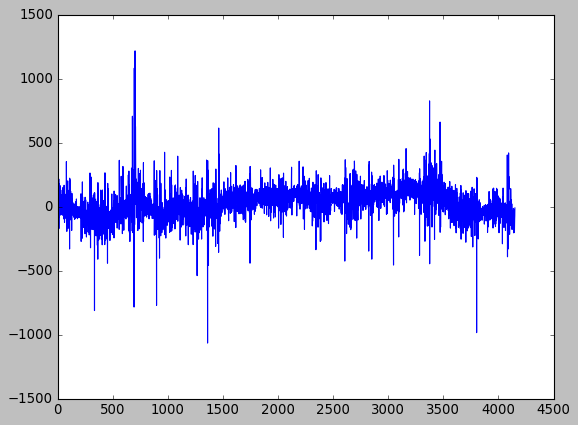

In [349]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)

rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-5)            
rfe = rfe.fit(train_X, train_y)

Train_X_std_rfe = train_X.loc[:,rfe.support_]
Test_X_std_rfe = test_X.loc[:,rfe.support_]
Val_X_std_rfe = val_X.loc[:,rfe.support_]

features_rfe.append(rfe.support_)

n_steps = 10
Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


train_y_rfe = train_y[n_steps - 1: -1]
val_y_rfe = val_y[n_steps - 1: -1]
test_y_rfe = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(Train_X_std_rfe, train_y_rfe, batch_size=32, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
# plot history

yhat_train = model.predict(Train_X_std_rfe)
yhat_test = model.predict(Test_X_std_rfe)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]

inv_yhat_train_RFE = yhat_train.reshape(yhat_train.shape[0])
inv_y_train_RFE = train_y_rfe.copy().values

for i in range(len(inv_yhat_train_RFE)):
    inv_yhat_train_RFE[i] = inv_yhat_train_RFE[i] * scale + mean
    inv_y_train_RFE[i] = inv_y_train_RFE [i] * scale + mean


inv_yhat_test_RFE = yhat_test.reshape(yhat_test.shape[0])
inv_y_test_RFE = test_y_rfe.copy().values
for i in range(len(inv_yhat_test_RFE)):
    inv_yhat_test_RFE[i] = inv_yhat_test_RFE[i] * scale + mean
    inv_y_test_RFE[i] = inv_y_test_RFE [i] * scale + mean
    
metrics(inv_y_test_RFE, inv_yhat_test_RFE)

PCA

In [ ]:
# split a multivariate sequence into samples
def split_sequences_PCA(df, n_steps):

    arrays = []
    for i in range(len(df.shape[0])):
        values = df[column].values
        a = values.reshape(len(values), 1)
        arrays.append(a)

    sequences = hstack((arrays))

    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences)-1:
            break

        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X)

In [223]:
from sklearn.decomposition import PCA

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)


Train_yhat_metrics_PCA={}
Train_yhat_metrics_PCA['RMSE'] = []
Train_yhat_metrics_PCA['MAPE'] = []
Train_yhat_metrics_PCA['SMAPE'] = []
Train_yhat_metrics_PCA['R2'] = []
Train_yhat_metrics_PCA['direction'] = []
Train_yhat_metrics_PCA['profit'] = []

Test_yhat_metrics_PCA={}
Test_yhat_metrics_PCA['RMSE'] = []
Test_yhat_metrics_PCA['MAPE'] = []
Test_yhat_metrics_PCA['SMAPE'] = []
Test_yhat_metrics_PCA['R2'] = []
Test_yhat_metrics_PCA['direction'] = []
Test_yhat_metrics_PCA['profit'] = []
 
m=train_X.shape[1]-1

features_pca = []

for i in range(m):
    
    pca = PCA(n_components=train_X.shape[1]-i)           
    
    Train_X_std_pca = pca.fit_transform(train_X)
    Val_X_std_pca = pca.fit_transform(val_X)
    Test_X_std_pca = pca.fit_transform(test_X)
    
    
    Train_X_std_pca = pd.DataFrame(Train_X_std_pca) 
    Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
    Val_X_std_pca = pd.DataFrame(Val_X_std_pca)


    n_steps = 10
    Train_X_std_pca = split_sequences(Train_X_std_pca, n_steps)
    Test_X_std_pca = split_sequences(Test_X_std_pca, n_steps)
    Val_X_std_pca = split_sequences(Val_X_std_pca, n_steps)

    train_y_pca = train_y[n_steps - 1: -1]
    val_y_pca = val_y[n_steps - 1: -1]
    test_y_pca = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(256, input_shape=(Train_X_std_pca.shape[1], Train_X_std_pca.shape[2]), activation = 'elu',return_sequences=True))
    model.add(LSTM(128, activation = 'elu',return_sequences=True))
    model.add(LSTM(56, activation = 'elu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
    # fit network
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
    model.fit(Train_X_std_pca, train_y_pca, batch_size=72, epochs=20, validation_data=(Val_X_std_pca, val_y_pca), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_pca)
    yhat_test = model.predict(Test_X_std_pca)

    mean = scaler.mean_
    mean = mean[len(mean) - 1]
    scale = scaler.scale_
    scale = scale[len(scale) - 1]
    inv_yhat_train_PCA = yhat_train.reshape(yhat_train.shape[0])
    inv_y_train_PCA = train_y_rfe.copy().values
    for i in range(len(inv_yhat_train_PCA)):
        inv_yhat_train_PCA[i] = inv_yhat_train_PCA[i] * scale + mean
        inv_y_train_PCA[i] = inv_y_train_PCA[i] * scale + mean

    inv_yhat_test_PCA = yhat_test.reshape(yhat_test.shape[0])
    inv_y_test_PCA = test_y_pca.copy().values
    for i in range(len(inv_yhat_test_PCA)):
        inv_yhat_test_PCA[i] = inv_yhat_test_PCA[i] * scale + mean
        inv_y_test_PCA[i] = inv_y_test_PCA[i] * scale + mean

    Train_yhat_metrics_PCA['RMSE'].append(np.sqrt(mean_squared_error(inv_y_train_PCA, inv_yhat_train_PCA)))
    Train_yhat_metrics_PCA['MAPE'].append(round((abs(inv_y_train_PCA-inv_yhat_train_PCA)/inv_y_train_PCA).mean(),4))
    Train_yhat_metrics_PCA['SMAPE'].append(round(np.sqrt(smape(inv_y_train_PCA, inv_yhat_train_PCA)),20))
    Train_yhat_metrics_PCA['R2'].append(round(r2_score(inv_y_train_PCA, inv_yhat_train_PCA),20))
    Train_yhat_metrics_PCA['direction'].append(round(direction(inv_y_train_PCA, inv_yhat_train_PCA),4))
    Train_yhat_metrics_PCA['profit'].append(round(count_money(inv_y_train_PCA, inv_yhat_train_PCA), 20))

    Test_yhat_metrics_PCA['RMSE'].append(np.sqrt(mean_squared_error(inv_y_test_PCA, inv_yhat_test_PCA)))
    Test_yhat_metrics_PCA['MAPE'].append(round((abs(inv_y_test_PCA-inv_yhat_test_PCA)/inv_y_test_PCA).mean(),4))
    Test_yhat_metrics_PCA['SMAPE'].append(round(np.sqrt(smape(inv_y_test_PCA, inv_yhat_test_PCA)),20))
    Test_yhat_metrics_PCA['R2'].append(round(r2_score(inv_y_test_PCA, inv_yhat_test_PCA),20))
    Test_yhat_metrics_PCA['direction'].append(round(direction(inv_y_test_PCA, inv_yhat_test_PCA),4))
    Test_yhat_metrics_PCA['profit'].append(round(count_money(inv_y_test_PCA, inv_yhat_test_PCA), 20))

Epoch 1/20
289/289 [==============================] - 46s 142ms/step - loss: 0.0232 - mean_absolute_error: 0.0915 - val_loss: 0.1333 - val_mean_absolute_error: 0.3515
Epoch 2/20
289/289 [==============================] - 41s 141ms/step - loss: 0.0064 - mean_absolute_error: 0.0535 - val_loss: 0.0752 - val_mean_absolute_error: 0.2643
Epoch 3/20
289/289 [==============================] - 40s 138ms/step - loss: 0.0040 - mean_absolute_error: 0.0419 - val_loss: 0.0723 - val_mean_absolute_error: 0.2603
Epoch 4/20
289/289 [==============================] - 40s 139ms/step - loss: 0.0029 - mean_absolute_error: 0.0366 - val_loss: 0.0810 - val_mean_absolute_error: 0.2812
Epoch 5/20
289/289 [==============================] - 40s 138ms/step - loss: 0.0023 - mean_absolute_error: 0.0330 - val_loss: 0.0650 - val_mean_absolute_error: 0.2349
Epoch 6/20
289/289 [==============================] - 40s 139ms/step - loss: 0.0019 - mean_absolute_error: 0.0304 - val_loss: 0.0722 - val_mean_absolute_error: 0.266

Epoch 5/20
289/289 [==============================] - 54s 187ms/step - loss: 0.0041 - mean_absolute_error: 0.0463 - val_loss: 0.0695 - val_mean_absolute_error: 0.2598
Epoch 6/20
289/289 [==============================] - 55s 189ms/step - loss: 0.0037 - mean_absolute_error: 0.0432 - val_loss: 0.0734 - val_mean_absolute_error: 0.2657
Epoch 7/20
203/203 [==============================] - 8s 39ms/step
Epoch 1/20
289/289 [==============================] - 52s 164ms/step - loss: 0.0295 - mean_absolute_error: 0.1002 - val_loss: 0.1202 - val_mean_absolute_error: 0.3256
Epoch 2/20
289/289 [==============================] - 52s 178ms/step - loss: 0.0083 - mean_absolute_error: 0.0648 - val_loss: 0.0722 - val_mean_absolute_error: 0.2620
Epoch 3/20
289/289 [==============================] - 57s 199ms/step - loss: 0.0058 - mean_absolute_error: 0.0544 - val_loss: 0.0777 - val_mean_absolute_error: 0.2737
Epoch 4/20
289/289 [==============================] - 54s 185ms/step - loss: 0.0047 - mean_absolut

Epoch 4/20
289/289 [==============================] - 48s 167ms/step - loss: 0.0055 - mean_absolute_error: 0.0532 - val_loss: 0.0776 - val_mean_absolute_error: 0.2707
Epoch 5/20
289/289 [==============================] - 48s 167ms/step - loss: 0.0048 - mean_absolute_error: 0.0493 - val_loss: 0.0686 - val_mean_absolute_error: 0.2594
Epoch 6/20
203/203 [==============================] - 7s 36ms/step
Epoch 1/20
289/289 [==============================] - 59s 188ms/step - loss: 0.0393 - mean_absolute_error: 0.1060 - val_loss: 0.0943 - val_mean_absolute_error: 0.3051
Epoch 2/20
289/289 [==============================] - 53s 182ms/step - loss: 0.0101 - mean_absolute_error: 0.0709 - val_loss: 0.0663 - val_mean_absolute_error: 0.2540
Epoch 3/20
289/289 [==============================] - 53s 183ms/step - loss: 0.0072 - mean_absolute_error: 0.0597 - val_loss: 0.0792 - val_mean_absolute_error: 0.2769
Epoch 4/20
289/289 [==============================] - 53s 182ms/step - loss: 0.0058 - mean_absolut

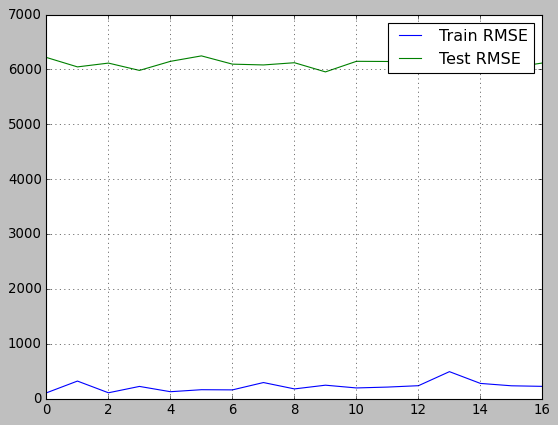

In [224]:
plt.plot(Train_yhat_metrics_PCA['RMSE'], label='Train RMSE')
plt.plot(Test_yhat_metrics_PCA['RMSE'], label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

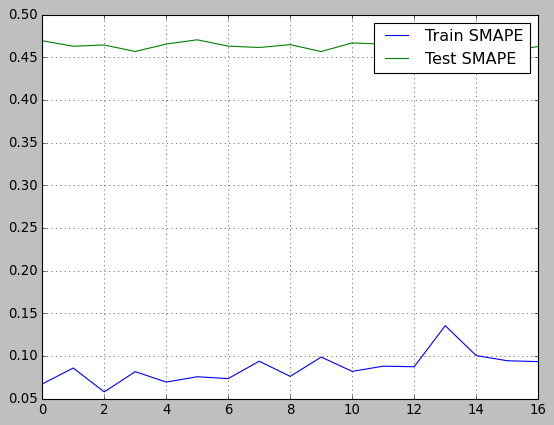

In [225]:
plt.plot(Train_yhat_metrics_PCA['SMAPE'], label='Train SMAPE')
plt.plot(Test_yhat_metrics_PCA['SMAPE'], label='Test SMAPE')
plt.legend()
plt.grid()
plt.show()

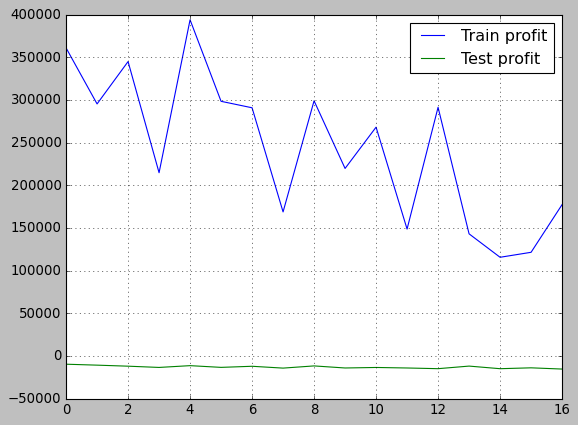

In [226]:
plt.plot(Train_yhat_metrics_PCA['profit'], label='Train profit')
plt.plot(Test_yhat_metrics_PCA['profit'], label='Test profit')
plt.legend()
plt.grid()
plt.show()

PCA плохо подходит для данной задачи, остановимся на RFE

# Quantity of candles Selection

In [336]:
train_X.loc[:, rfe.support_]

,close,macd,signal_line,histogram,width_open_close
0,3.475376,-0.187113,-0.242436,0.143194,-0.173908
1,3.478763,-0.171614,-0.230259,0.156824,0.158996
2,3.466651,-0.195033,-0.225474,0.061458,-0.520308
3,3.480713,-0.165957,-0.215492,0.128511,0.626862
4,3.461622,-0.200861,-0.214895,0.007445,-0.826220
...,...,...,...,...,...
13307,0.280693,-0.028025,0.027586,-0.184627,0.091516
13308,0.277922,-0.046200,0.012306,-0.197384,-0.110926
13309,0.301222,0.014483,0.012927,0.007745,1.031745
13310,0.294858,0.042509,0.019356,0.082675,-0.268381


In [337]:
For_Comparing_candles = pd.DataFrame(np.zeros([4,5]), columns=['R2','SMAPE','SE','Среднее угадывание направления','Прибыль'])

def Evaluate_candles(n, real,forecast):
   
    For_Comparing_candles.loc[n,'R2']  = round(r2_score(real,forecast),20)
    For_Comparing_candles.loc[n,'SMAPE']   = round(np.sqrt(smape(real, forecast)),20)
    For_Comparing_candles.loc[n,'SE'] = round(((real-forecast)**2).mean()**0.5,4)
    For_Comparing_candles.loc[n,'Среднее угадывание направления']  = round(direction(real, forecast),20)
    For_Comparing_candles.loc[n,'Прибыль']= round(count_money(real, forecast),20)

In [338]:
df = df_candles_supervised[['close','macd','signal_line','histogram', 'width_open_close', 'close_next']]
df

,close,macd,signal_line,histogram,width_open_close,close_next
0,38572.5,-31.211522,-36.379308,5.167786,-20.5,38589.0
1,38589.0,-29.305824,-34.964611,5.658787,16.5,38530.0
2,38530.0,-32.185339,-34.408757,2.223418,-59.0,38598.5
3,38598.5,-28.610198,-33.249045,4.638847,68.5,38505.5
4,38505.5,-32.901922,-33.179620,0.277699,-93.0,38392.0
...,...,...,...,...,...,...
20795,30266.4,49.328030,34.495940,14.832091,-77.9,30221.7
20796,30221.7,40.811336,35.759019,5.052317,-44.7,30181.0
20797,30181.0,30.426901,34.692595,-4.265694,-40.7,30149.9
20798,30149.9,19.463292,31.646735,-12.183443,-31.1,30163.7


In [339]:
def build_model(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    BatchNormalization(),
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

In [340]:
def split_and_normalization(dataset):
    split = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split)
    val = train[i_split_val:]
    train = train[:i_split_val]

    features = dataset.columns.values

    train_norm = train.values
    train_norm = scaler.fit_transform(train_norm)
    train_norm = pd.DataFrame(train_norm, columns=features)
    
    # test

    test_norm = test.values
    test_norm = scaler.transform(test_norm)
    test_norm = pd.DataFrame(test_norm, columns=features)
    
    
    # val
    val_norm = val.values
    val_norm = scaler.transform(val_norm)
    val_norm = pd.DataFrame(val_norm, columns=features)



    train_X = train_norm.drop(['close_next'],axis=1)
    # train_X.index = train_X['date']
    # train_X = train_X.drop(['date'],axis=1)
    train_y = train_norm['close_next']
    
    test_X = test_norm.drop(['close_next'],axis=1)
    # test_X.index = test_X['date']
    # test_X = test_X.drop(['date'],axis=1)
    test_y = test_norm['close_next']


    val_X = val_norm.drop(['close_next'],axis=1)
    # val_X.index = val_X['date']
    # val_X = val_X.drop(['date'],axis=1)
    val_y = val_norm['close_next']

    return train_X, train_y, test_X, test_y, val_X, val_y

Выберем оптимальное количество свечей в последовательности

3 свечи

Epoch 1/20
416/416 [==============================] - 22s 41ms/step - loss: 0.0404 - mean_absolute_error: 0.1010 - val_loss: 0.0025 - val_mean_absolute_error: 0.0405
Epoch 2/20
416/416 [==============================] - 16s 38ms/step - loss: 0.0083 - mean_absolute_error: 0.0571 - val_loss: 0.0014 - val_mean_absolute_error: 0.0281
Epoch 3/20
416/416 [==============================] - 17s 41ms/step - loss: 0.0061 - mean_absolute_error: 0.0491 - val_loss: 0.0038 - val_mean_absolute_error: 0.0503
Epoch 4/20
416/416 [==============================] - 17s 42ms/step - loss: 0.0052 - mean_absolute_error: 0.0452 - val_loss: 0.0018 - val_mean_absolute_error: 0.0314
Epoch 5/20
416/416 [==============================] - 19s 46ms/step - loss: 0.0043 - mean_absolute_error: 0.0427 - val_loss: 0.0012 - val_mean_absolute_error: 0.0250
Epoch 6/20
416/416 [==============================] - 20s 47ms/step - loss: 0.0037 - mean_absolute_error: 0.0390 - val_loss: 5.7984e-04 - val_mean_absolute_error: 0.0156


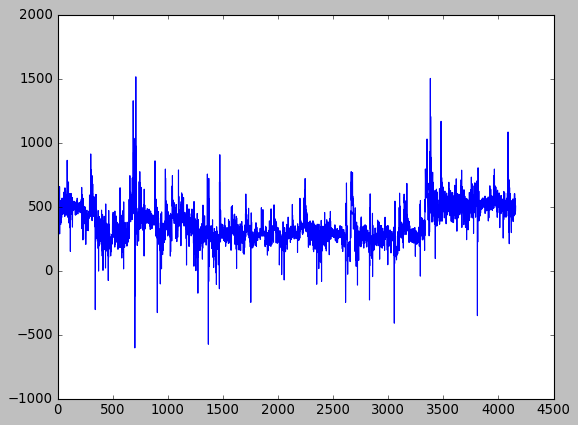

In [341]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 3
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat = model.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_3 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_3= test_y.values
for i in range(len(inv_yhat_OHLCV_3)):
    inv_yhat_OHLCV_3[i] = inv_yhat_OHLCV_3[i] * scale + mean
    inv_y_OHLCV_3[i] = inv_y_OHLCV_3[i] * scale + mean

metrics(inv_y_OHLCV_3, inv_yhat_OHLCV_3)

In [342]:
Evaluate_candles(0, inv_y_OHLCV_3, inv_yhat_OHLCV_3)

5 свечей

Epoch 1/20
416/416 [==============================] - 28s 58ms/step - loss: 0.0532 - mean_absolute_error: 0.1104 - val_loss: 0.0217 - val_mean_absolute_error: 0.1076
Epoch 2/20
416/416 [==============================] - 24s 59ms/step - loss: 0.0097 - mean_absolute_error: 0.0631 - val_loss: 0.0038 - val_mean_absolute_error: 0.0435
Epoch 3/20
416/416 [==============================] - 26s 63ms/step - loss: 0.0067 - mean_absolute_error: 0.0517 - val_loss: 0.0012 - val_mean_absolute_error: 0.0225
Epoch 4/20
416/416 [==============================] - 26s 61ms/step - loss: 0.0055 - mean_absolute_error: 0.0470 - val_loss: 0.0019 - val_mean_absolute_error: 0.0316
Epoch 5/20
416/416 [==============================] - 26s 63ms/step - loss: 0.0045 - mean_absolute_error: 0.0435 - val_loss: 0.0100 - val_mean_absolute_error: 0.0777
Epoch 6/20
130/130 [==============================] - 3s 19ms/step
Тест на стационарность:
	T-статистика = -3.056
	P-значение = 0.030
Критические значения :
	1%: -3.43193

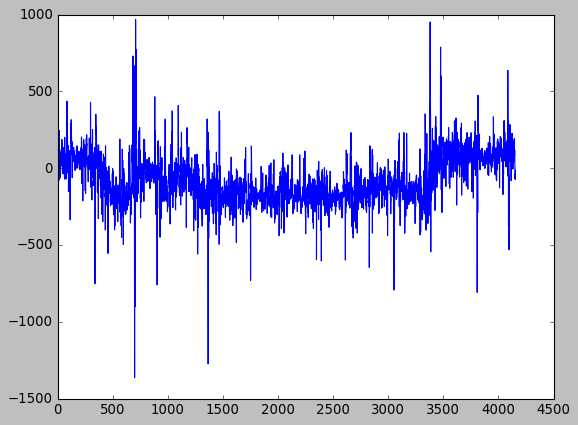

In [343]:
best_models_candle_5 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 5
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat = model.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_5 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_5= test_y.values
for i in range(len(inv_yhat_OHLCV_5)):
    inv_yhat_OHLCV_5[i] = inv_yhat_OHLCV_5[i] * scale + mean
    inv_y_OHLCV_5[i] = inv_y_OHLCV_5[i] * scale + mean

metrics(inv_y_OHLCV_5, inv_yhat_OHLCV_5)

In [344]:
Evaluate_candles(1, inv_y_OHLCV_5, inv_yhat_OHLCV_5)

10 свечей

Epoch 1/20
416/416 [==============================] - 56s 123ms/step - loss: 0.0484 - mean_absolute_error: 0.1156 - val_loss: 0.0117 - val_mean_absolute_error: 0.0818
Epoch 2/20
416/416 [==============================] - 52s 126ms/step - loss: 0.0107 - mean_absolute_error: 0.0627 - val_loss: 0.0018 - val_mean_absolute_error: 0.0291
Epoch 3/20
416/416 [==============================] - 50s 119ms/step - loss: 0.0070 - mean_absolute_error: 0.0522 - val_loss: 0.0020 - val_mean_absolute_error: 0.0316
Epoch 4/20
416/416 [==============================] - 50s 121ms/step - loss: 0.0053 - mean_absolute_error: 0.0461 - val_loss: 0.0101 - val_mean_absolute_error: 0.0757
Epoch 5/20
130/130 [==============================] - 5s 35ms/step
Тест на стационарность:
	T-статистика = -7.335
	P-значение = 0.000
Критические значения :
	1%: -3.4319370424399875 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.862241268318593 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.567143291608058

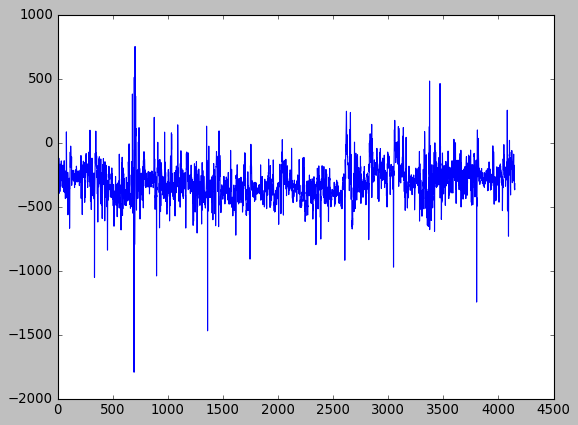

In [345]:
best_models_candle_10 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 10
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat = model.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_10 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_10= test_y.values
for i in range(len(inv_yhat_OHLCV_10)):
    inv_yhat_OHLCV_10[i] = inv_yhat_OHLCV_10[i] * scale + mean
    inv_y_OHLCV_10[i] = inv_y_OHLCV_10[i] * scale + mean

metrics(inv_y_OHLCV_10, inv_yhat_OHLCV_10)

In [346]:
Evaluate_candles(2, inv_y_OHLCV_10, inv_yhat_OHLCV_10)

20 свечей

In [347]:
best_models_candle_20 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 20
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat = model.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_20 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_20= test_y.values
for i in range(len(inv_yhat_OHLCV_20)):
    inv_yhat_OHLCV_20[i] = inv_yhat_OHLCV_20[i] * scale + mean
    inv_y_OHLCV_20[i] = inv_y_OHLCV_20[i] * scale + mean

metrics(inv_y_OHLCV_20, inv_yhat_OHLCV_20)

Epoch 1/20
416/416 [==============================] - 111s 250ms/step - loss: 0.1286 - mean_absolute_error: 0.1348 - val_loss: 0.0072 - val_mean_absolute_error: 0.0642
Epoch 2/20
416/416 [==============================] - 103s 248ms/step - loss: 0.0112 - mean_absolute_error: 0.0654 - val_loss: 0.0030 - val_mean_absolute_error: 0.0405
Epoch 3/20
416/416 [==============================] - 104s 250ms/step - loss: 0.0071 - mean_absolute_error: 0.0538 - val_loss: 0.0058 - val_mean_absolute_error: 0.0681
Epoch 4/20
416/416 [==============================] - 102s 246ms/step - loss: 0.0055 - mean_absolute_error: 0.0469 - val_loss: 0.0062 - val_mean_absolute_error: 0.0565
Epoch 5/20
416/416 [==============================] - 102s 246ms/step - loss: 0.0045 - mean_absolute_error: 0.0442 - val_loss: 0.0020 - val_mean_absolute_error: 0.0330
Epoch 6/20
257/416 [=================>............] - ETA: 38s - loss: 0.0038 - mean_absolute_error: 0.0404

KeyboardInterrupt: 

In [ ]:
Evaluate_candles(3, inv_y_OHLCV_20, inv_yhat_OHLCV_20)

In [ ]:
Table_of_Comapring_candles = For_Comparing_candles.copy()
Table_of_Comapring_candles.index = ['3','5','10', '20']
Table_of_Comapring_candles

Лучшим оказались последовательности длиной 3

# NN selection

Выбор наилучшего архитектуры

In [216]:
For_Comparing_NN = pd.DataFrame(np.zeros([5,5]), columns=['R2','SMAPE','SE','Среднее угадывание направления','Прибыль'])

def Evaluate_NN(n, real,forecast):
   
    For_Comparing_NN.loc[n,'R2']  = round(r2_score(real,forecast),20)
    For_Comparing_NN.loc[n,'SMAPE']   = round(np.sqrt(smape(real, forecast)),20)
    For_Comparing_NN.loc[n,'SE'] = round(((real-forecast)**2).mean()**0.5,4)
    For_Comparing_NN.loc[n,'Среднее угадывание направления']  = round(direction(real, forecast),20)
    For_Comparing_NN.loc[n,'Прибыль']= round(count_money(real, forecast),20)


In [217]:
n_steps = 3

LSTM

Trial 5 Complete [00h 11m 12s]
val_mean_absolute_error: 0.019203854724764824

Best val_mean_absolute_error So Far: 0.0032783541828393936
Total elapsed time: 00h 38m 53s
INFO:tensorflow:Oracle triggered exit
131/131 [==============================] - 4s 23ms/step
Тест на стационарность:
	T-статистика = -2.329
	P-значение = 0.163
Критические значения :
	1%: -3.431932816913897 - Данные не стационарны с вероятностью 99% процентов
	5%: -2.862239401676958 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.5671422978923997 - Данные не стационарны с вероятностью 90% процентов
MAD: 21.42
MSE: 730.7712
MAPE: 0.0008
MPE: -0.0001
Стандартная ошибка: 27.0328
Среднее угадывание направления:  0.8383377372087437
R2: 0.999690817631798
SMAPE: 0.027635357335846076
Прибыль, при условии закрытия сделки по каждой свечи: 204632.66935501157
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): 175932.51698364475


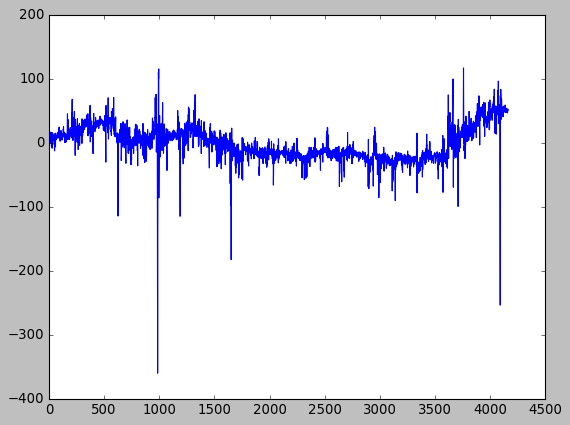

In [218]:
def build_model_LSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

best_models_LSTM = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_LSTM,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTCLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_LSTM.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_LSTM = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_LSTM= test_y.values
for i in range(len(inv_yhat_OHLCV_LSTM)):
    inv_yhat_OHLCV_LSTM[i] = inv_yhat_OHLCV_LSTM[i] * scale + mean
    inv_y_OHLCV_LSTM[i] = inv_y_OHLCV_LSTM[i] * scale + mean

metrics(inv_y_OHLCV_LSTM, inv_yhat_OHLCV_LSTM)

In [219]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 344)            482976    
                                                                 
 lstm_1 (LSTM)               (None, 3, 168)            344736    
                                                                 
 lstm_2 (LSTM)               (None, 3, 168)            226464    
                                                                 
 lstm_3 (LSTM)               (None, 64)                59648     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,113,889
Trainable params: 1,113,889
Non-trainable params: 0
_________________________________________________________________


In [220]:
Evaluate_NN(0, inv_y_OHLCV_LSTM, inv_yhat_OHLCV_LSTM)

GRU

Trial 5 Complete [00h 08m 01s]
val_mean_absolute_error: 0.008608431555330753

Best val_mean_absolute_error So Far: 0.003505357773974538
Total elapsed time: 00h 32m 18s
INFO:tensorflow:Oracle triggered exit
131/131 [==============================] - 4s 26ms/step
Тест на стационарность:
	T-статистика = -4.950
	P-значение = 0.000
Критические значения :
	1%: -3.4319301396383657 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8622382189793107 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.567141668277847 - Данные  стационарны с вероятностью 90% процентов
MAD: 13.9115
MSE: 406.0272
MAPE: 0.0005
MPE: -0.0001
Стандартная ошибка: 20.1501
Среднее угадывание направления:  0.9053567139082392
R2: 0.9998282137440674
SMAPE: 0.022053151220388034
Прибыль, при условии закрытия сделки по каждой свечи: 212779.20621705992
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): 190800.48302149965


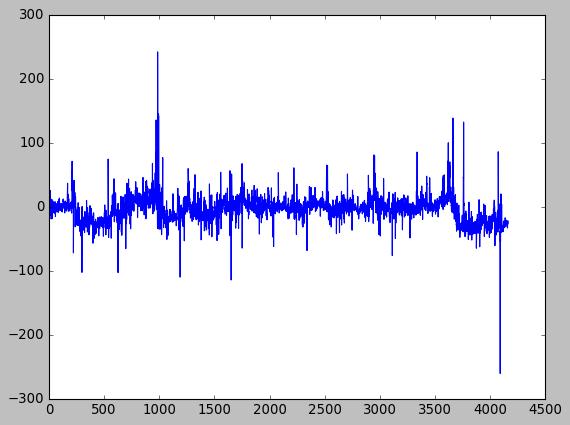

In [221]:
def build_model_GRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(GRU(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(GRU(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

best_models_GRU = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_GRU,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTCLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_GRU.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_GRU = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_GRU= test_y.values
for i in range(len(inv_yhat_OHLCV_GRU)):
    inv_yhat_OHLCV_GRU[i] = inv_yhat_OHLCV_GRU[i] * scale + mean
    inv_y_OHLCV_GRU[i] = inv_y_OHLCV_GRU[i] * scale + mean

metrics(inv_y_OHLCV_GRU, inv_yhat_OHLCV_GRU)

In [222]:
best_models_GRU[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 352)            380160    
                                                                 
 gru_1 (GRU)                 (None, 3, 152)            230736    
                                                                 
 gru_2 (GRU)                 (None, 3, 152)            139536    
                                                                 
 gru_3 (GRU)                 (None, 3, 152)            139536    
                                                                 
 gru_4 (GRU)                 (None, 80)                56160     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 946,209
Trainable params: 946,209
Non-trai

In [223]:
Evaluate_NN(1, inv_y_OHLCV_GRU, inv_yhat_OHLCV_GRU)

BiLSTM

Trial 5 Complete [00h 06m 07s]
val_mean_absolute_error: 0.02089705877006054

Best val_mean_absolute_error So Far: 0.00450216606259346
Total elapsed time: 00h 41m 16s
INFO:tensorflow:Oracle triggered exit
131/131 [==============================] - 6s 30ms/step
Тест на стационарность:
	T-статистика = -7.667
	P-значение = 0.000
Критические значения :
	1%: -3.4319309036495986 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8622385564845723 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.567141847950313 - Данные  стационарны с вероятностью 90% процентов
MAD: 22.827
MSE: 919.6805
MAPE: 0.0008
MPE: 0.0005
Стандартная ошибка: 30.3262
Среднее угадывание направления:  0.8337737208743694
R2: 0.9996108918807161
SMAPE: 0.028655485738905827
Прибыль, при условии закрытия сделки по каждой свечи: 199499.72425222662
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): 175838.29254385823


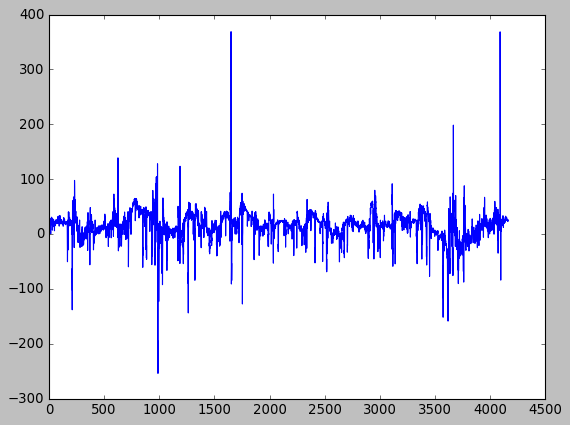

In [224]:
def build_model_BiLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True)))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(Bidirectional(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True)))
    
    model.add(Bidirectional(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice)))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

best_models_BiLSTM = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_BiLSTM,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTCLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_BiLSTM.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_BiLSTM = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_BiLSTM= test_y.values
for i in range(len(inv_yhat_OHLCV_BiLSTM)):
    inv_yhat_OHLCV_BiLSTM[i] = inv_yhat_OHLCV_BiLSTM[i] * scale + mean
    inv_y_OHLCV_BiLSTM[i] = inv_y_OHLCV_BiLSTM[i] * scale + mean

metrics(inv_y_OHLCV_BiLSTM, inv_yhat_OHLCV_BiLSTM)

In [225]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 768)           1201152   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 240)              853440    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 241       
                                                                 
Total params: 2,054,833
Trainable params: 2,054,833
Non-trainable params: 0
_________________________________________________________________


In [226]:
Evaluate_NN(2, inv_y_OHLCV_BiLSTM, inv_yhat_OHLCV_BiLSTM)

BiGRU

Trial 5 Complete [00h 11m 56s]
val_mean_absolute_error: 0.012440234422683716

Best val_mean_absolute_error So Far: 0.007410787045955658
Total elapsed time: 01h 05m 05s
INFO:tensorflow:Oracle triggered exit
131/131 [==============================] - 14s 77ms/step
Тест на стационарность:
	T-статистика = -3.729
	P-значение = 0.004
Критические значения :
	1%: -3.431929376365231 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8622378818000214 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5671414887789292 - Данные  стационарны с вероятностью 90% процентов
MAD: 47.9739
MSE: 3784.5758
MAPE: 0.0017
MPE: -0.0002
Стандартная ошибка: 61.5189
Среднее угадывание направления:  0.7744415085275042
R2: 0.9983987818244705
SMAPE: 0.04102138873978293
Прибыль, при условии закрытия сделки по каждой свечи: 182683.88066012616
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): 163320.17091903888


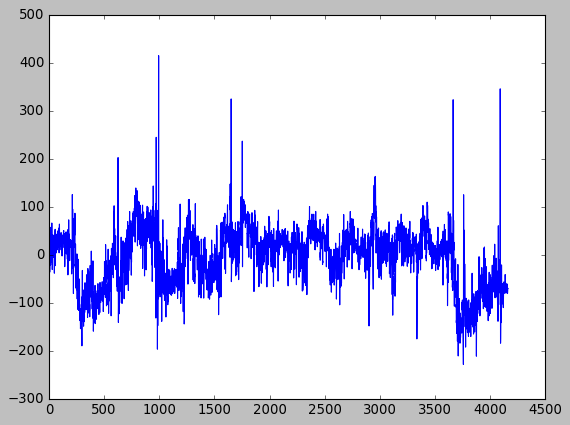

In [227]:
def build_model_BiGRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True)))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(Bidirectional(GRU(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True)))
    
    model.add(Bidirectional(GRU(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice)))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model


best_models_BiGRU = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)



train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_BiGRU,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTCLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_BiGRU.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_BiGRU = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_BiGRU= test_y.values
for i in range(len(inv_yhat_OHLCV_BiGRU)):
    inv_yhat_OHLCV_BiGRU[i] = inv_yhat_OHLCV_BiGRU[i] * scale + mean
    inv_y_OHLCV_BiGRU[i] = inv_y_OHLCV_BiGRU[i] * scale + mean

metrics(inv_y_OHLCV_BiGRU, inv_yhat_OHLCV_BiGRU)

In [124]:
inv_y_OHLCV_BiLSTM

array([28072.13032244, 28086.38181415, 28075.08631968, ...,
       29966.64367337, 30062.66473242, 30049.75387415])

In [228]:
best_models_BiGRU[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 944)           1359360   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 496)           1776672   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 3, 496)           1110048   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 3, 496)           1110048   
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 176)              3

In [229]:
Evaluate_NN(3, inv_y_OHLCV_BiGRU, inv_yhat_OHLCV_BiGRU)

In [230]:
from tensorflow.keras.layers import ConvLSTM2D

Conv-LSTM

Trial 5 Complete [00h 00m 44s]
val_mean_absolute_error: 0.005359495058655739

Best val_mean_absolute_error So Far: 0.0033037352841347456
Total elapsed time: 00h 04m 07s
INFO:tensorflow:Oracle triggered exit
131/131 [==============================] - 1s 3ms/step
Тест на стационарность:
	T-статистика = -7.188
	P-значение = 0.000
Критические значения :
	1%: -3.4319316684000016 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.862238894316278 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5671420277965775 - Данные  стационарны с вероятностью 90% процентов
MAD: 17.6918
MSE: 586.2379
MAPE: 0.0006
MPE: -0.0004
Стандартная ошибка: 24.2124
Среднее угадывание направления:  0.8784530386740331
R2: 0.9997519682821009
SMAPE: 0.025053501775778423
Прибыль, при условии закрытия сделки по каждой свечи: 209502.61885730957
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): 184021.64179944043


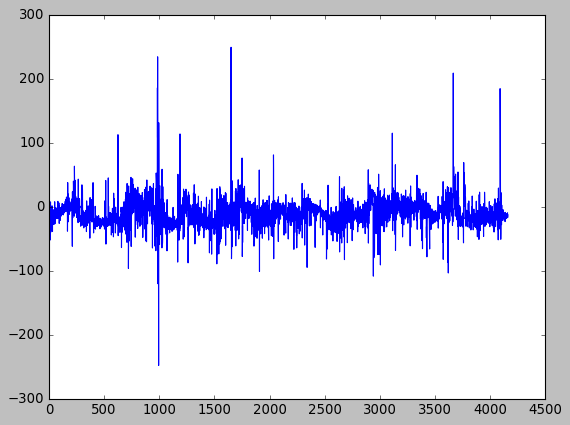

In [231]:
def build_model_ConvLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(ConvLSTM2D(input_shape=(1, 1, train_X.shape[3], train_X.shape[4]),
                            activation=activation_choice, filters=32, padding='same', kernel_size=(1,5)))
    
    model.add(Flatten())
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)

train_X = train_X.reshape((train_X.shape[0], 1, 1, train_X.shape[1],train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], 1, 1, test_X.shape[1],test_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], 1, 1, val_X.shape[1],val_X.shape[2]))

print(train_X.shape)

train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]

from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_ConvLSTM,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTC1HCONVLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_ConvLSTM = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_ConvLSTM= test_y.values
for i in range(len(inv_yhat_OHLCV_ConvLSTM)):
    inv_yhat_OHLCV_ConvLSTM[i] = inv_yhat_OHLCV_ConvLSTM[i] * scale + mean
    inv_y_OHLCV_ConvLSTM[i] = inv_y_OHLCV_ConvLSTM[i] * scale + mean

metrics(inv_y_OHLCV_ConvLSTM, inv_yhat_OHLCV_ConvLSTM)

In [232]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 3, 32)          24448     
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 24,545
Trainable params: 24,545
Non-trainable params: 0
_________________________________________________________________


In [233]:
Evaluate_NN(4, inv_y_OHLCV_ConvLSTM, inv_yhat_OHLCV_ConvLSTM)

In [234]:
Table_of_Comapring_NN = For_Comparing_NN.copy()
Table_of_Comapring_NN.index = ['LSTM','GRU','BiLSTM','BiGRU','CONV-LSTM']
Table_of_Comapring_NN

,R2,SMAPE,SE,Среднее угадывание направления,Прибыль
LSTM,0.999691,0.027635,27.0328,0.838338,204632.669355
GRU,0.999828,0.022053,20.1501,0.905357,212779.206217
BiLSTM,0.999611,0.028655,30.3262,0.833774,199499.724252
BiGRU,0.998399,0.041021,61.5189,0.774442,182683.880660
CONV-LSTM,0.999752,0.025054,24.2124,0.878453,209502.618857


In [81]:
best_models_GRU[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 440)           592680    
                                                                 
 gru_1 (GRU)                 (None, 10, 184)           345552    
                                                                 
 gru_2 (GRU)                 (None, 10, 184)           204240    
                                                                 
 gru_3 (GRU)                 (None, 88)                72336     
                                                                 
 dense (Dense)               (None, 1)                 89        
                                                                 
Total params: 1,214,897
Trainable params: 1,214,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
(inv_y_OHLCV_GRU, inv_yhat_OHLCV_GRU)

In [240]:
money = {}
j = 0 
for i in range(len(inv_y_OHLCV_GRU) // 48):
    count_money_100 = direction(inv_y_OHLCV_GRU[j:j+48], inv_yhat_OHLCV_GRU[j:j+48])
    money[i] = count_money_100
    j = j + 48
    print(i,' : ',count_money_100)

0  :  0.9787234042553191
1  :  0.9787234042553191
2  :  0.9574468085106383
3  :  0.9787234042553191
4  :  0.9361702127659575
5  :  0.8297872340425532
6  :  0.7659574468085106
7  :  0.9574468085106383
8  :  0.7446808510638298
9  :  0.6595744680851063
10  :  0.7446808510638298
11  :  0.851063829787234
12  :  0.8936170212765957
13  :  0.9148936170212766
14  :  0.9787234042553191
15  :  0.9361702127659575
16  :  0.9361702127659575
17  :  0.9574468085106383
18  :  0.8936170212765957
19  :  0.9361702127659575
20  :  0.9361702127659575
21  :  0.9148936170212766
22  :  0.8085106382978723
23  :  0.851063829787234
24  :  0.8936170212765957
25  :  0.9574468085106383
26  :  0.9148936170212766
27  :  0.9787234042553191
28  :  0.9787234042553191
29  :  0.9361702127659575
30  :  0.9148936170212766
31  :  0.9787234042553191
32  :  0.9361702127659575
33  :  0.8723404255319149
34  :  0.8936170212765957
35  :  0.9574468085106383
36  :  0.851063829787234
37  :  0.9574468085106383
38  :  0.9361702127659575

Лучше всего себя показали GRU сеть

Сохранить лучшую модель в C:\Users\LENOVO\PycharmProjects\trading_robot

In [237]:
best_models_GRU[0].save('best_model_30min_06.07.23')

INFO:tensorflow:Assets written to: best_model_30min_06.07.23\assets


In [38]:
print(scaler.mean_[0], scaler.scale_[0])

20822.2109375 3605.997846008538


In [239]:
# scaler is fitted instance of MinMaxScaler
scaler_data_ = np.array([scaler.mean_, scaler.scale_])
np.save("my_scaler.npy", scaler_data_,  allow_pickle=False)